# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
# Let's get info on the user-item-interactions df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [4]:
# Let's get info on the articles_community df
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [5]:
df_content[df_content['article_id'] == 1427]

,doc_body,doc_description,doc_full_name,doc_status,article_id


In [6]:
# Let's get some stats
# number of articles
print("number of articles=", df_content['article_id'].count())
# number of uniuqe articles
print("number of uniuqe articles =", df_content.article_id.nunique())
# number of doc_status
print("number of doc_status=", df_content['doc_status'].count())
# number of unique users
print("number of unique users=", df.email.nunique())

number of articles= 1056
number of uniuqe articles = 1051
number of doc_status= 1056
number of unique users= 5148


In [7]:
# What's the Proportion of missing values for each column.
print("Proportion missing values in user-item-interactions")
df.isna().mean() * 100

Proportion missing values in user-item-interactions


article_id    0.000000
title         0.000000
email         0.036962
dtype: float64

In [8]:
# What's the Proportion of missing values for each column.
print("Proportion missing values in articles_community")
df_content.isna().mean() * 100

Proportion missing values in articles_community


doc_body           1.325758
doc_description    0.284091
doc_full_name      0.000000
doc_status         0.000000
article_id         0.000000
dtype: float64

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

<AxesSubplot: title={'center': 'How many articles a user interacts with'}, ylabel='Frequency'>

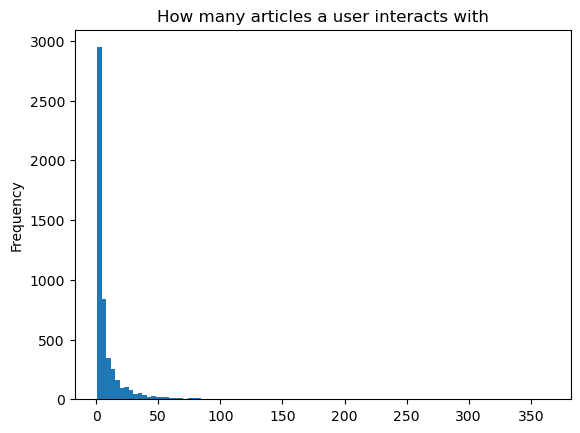

In [9]:
#distribution of how many articles a user interacts with in the
datasetdf_freq_knt = df.groupby('email')['article_id'].count()
datasetdf_freq_knt.plot(kind='hist',
                        bins=100,
                        title="How many articles a user interacts with")

In [10]:
# compute some descriptive statistics
print('Descriptive Statistics for Number of Interactions per User')
print('---------------------------------------------------------')
print(datasetdf_freq_knt.describe())

Descriptive Statistics for Number of Interactions per User
---------------------------------------------------------
count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


In [11]:
# Median and maximum number of user_article interactios below
median_val = datasetdf_freq_knt.median()
max_views_by_user = datasetdf_freq_knt.max()

print(
    "50% of individuals interact with {} articles or fewer".format(median_val))
print("The maximum number of user-article interactions by any 1 user is {}".
      format(max_views_by_user))

50% of individuals interact with 3.0 articles or fewer
The maximum number of user-article interactions by any 1 user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [12]:
# number of unique articles in df_contents
print("Number of article_ids", df_content.article_id.nunique())

Number of article_ids 1051


In [13]:
# Count duplicate rows based on article_id
dup_articles_knt = df_content.shape[0] - df_content.article_id.nunique()
print("So there are  {} duplicate articles in df_contents".format(
    dup_articles_knt))

# select the duplicate rows based on article_id
duplicate_rows = df_content[df_content.duplicated(
    'article_id', keep=False)].sort_values('article_id')

# print the duplicate rows
print('Duplicate Rows:')
display(duplicate_rows)

So there are  5 duplicate articles in df_contents
Duplicate Rows:


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [14]:
# Remove any rows that have the same article_id - only keep the first
df_content_uniq = df_content.drop_duplicates(subset='article_id', keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
# number of unique articles that have an interaction with a user.
unique_articles = len(df['article_id'].unique())

# number of unique articles in the dataset (whether they have any interactions or not).
total_articles = len(df_content['article_id'].unique())

#  number of unique users in the dataset. (excluding null values)
unique_users = len(df.dropna(subset=['email'])['email'].unique())

# number of user-article interactions in the dataset
user_article_interactions = df.shape[0]

# print the results
print('Number of unique articles with at least one interaction: {}'.format(
    unique_articles))
print('Number of unique articles in the dataset: {}'.format(total_articles))
print('Number of unique users in the dataset: {}'.format(unique_users))
print('Number of user-article interactions in the dataset: {}'.format(
    user_article_interactions))

Number of unique articles with at least one interaction: 714
Number of unique articles in the dataset: 1051
Number of unique users in the dataset: 5148
Number of user-article interactions in the dataset: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
# group the df by article_id and count the number of views for each article
article_views = df.groupby('article_id')['email'].count().reset_index()

# sort the articles by the number of views in descending order
article_views_sorted = article_views.sort_values('email', ascending=False)

# get the most viewed article_id and its view count
most_viewed_article_id = str(article_views_sorted.iloc[0]['article_id'])
max_views = article_views_sorted.iloc[0]['email']

# print the results
print('The most viewed article is "{}" with {} views.'.format(
    most_viewed_article_id, max_views))
print('The most viewed article "{}"'.format(
    df[df['article_id'] == float(most_viewed_article_id)].iloc[0, 1:2]))

The most viewed article is "1429.0" with 937.0 views.
The most viewed article "title    use deep learning for image classification
Name: 2, dtype: object"


In [17]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column


def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

        email_encoded.append(coded_dict[val])
    return email_encoded


email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [18]:
## If you stored all your results in the variable names above,
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`':
    user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`':
    max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`':
    max_views,
    '`The article_id of the most viewed article is ______.`':
    most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`':
    unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [19]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    '''
    top_articles = df['title'].value_counts().head(n).index.tolist()
    return top_articles

In [20]:
print(get_top_articles(3))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel']


In [21]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    top_article_ids = df['article_id'].value_counts().head(n).index.tolist()

    return top_article_ids

In [22]:
print(get_top_article_ids(3))

[1429.0, 1330.0, 1431.0]


In [23]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [24]:
# test the steps
# tmp1 = df.groupby(['user_id', 'article_id'])['title'].max()
# tmp1.unstack().notnull().astype(int)

In [25]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Convert article_id to numeric values and drop rows with non-numeric values
    df['article_id'] = pd.to_numeric(df['article_id'], errors='coerce')
    df = df.dropna(subset=['article_id'])

    # Convert user_id to numeric values and drop rows with non-numeric values
    df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce')
    df = df.dropna(subset=['user_id'])

    # Create user-item matrix with 1's and 0's
    user_item = df.groupby(['user_id', 'article_id'
                            ])['title'].max().unstack().notna().astype(int)
    return user_item

In [26]:
# create the user-article matrix with 1's and 0's
user_item = create_user_item_matrix(df)

#Let's get summary stats
user_item.describe()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
count,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,...,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000
mean,0.002331,0.008545,0.002525,0.015925,0.001942,0.019227,0.017285,0.005050,0.010876,0.013206,...,0.006992,0.014566,0.054768,0.024665,0.008351,0.001554,0.001165,0.000777,0.002331,0.000971
std,0.048224,0.092054,0.050188,0.125199,0.044031,0.137335,0.130344,0.070887,0.103729,0.114169,...,0.083331,0.119819,0.227549,0.155117,0.091011,0.039390,0.034120,0.027864,0.048224,0.031150
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
# test the diff between using notnull and notna in the function above
user_item1 = df.groupby(['user_id', 'article_id'
                         ])['title'].max().unstack().notnull().astype(int)
user_item1.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# test the diff between using notnull and notna in the function above
print((user_item1 == user_item).mean(axis=0).sum())
print((user_item1 == user_item).mean(axis=1).sum())

714.0
5149.0


In [29]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[
    0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[
    1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(
    axis=1
)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [30]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of users ids from most to least similar
    
    '''
    # compute similarity of each user to the provided user
    user_vector = user_item.loc[user_id]
    similarities = user_item.dot(user_vector)

    # sort by similarity
    similarities = similarities.sort_values(ascending=False)

    # create list of just the ids
    most_similar_users = list(similarities.index)

    # remove the own user's id
    most_similar_users.remove(user_id)

    return most_similar_users  # return a list of the users in order from most to least similar

In [31]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(
    find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(
    find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(
    find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [32]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Convert article_ids to numeric if not already numeric
    newarticles = []
    for id in article_ids:
        # print(id)
        if isinstance(id, str) or id.isnumeric():
            newarticles.append(float(id))
        else:
            newarticles.append(id)

    # Get article names for the given article_ids
    article_names = df[df['article_id'].isin(
        newarticles)]['title'].unique().tolist()

    return article_names

In [33]:
# Let's validate the function
article_ids = ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
get_article_names(article_ids, df)

['healthcare python streaming application demo',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for naive bayes model',
 'use r dataframes & ibm watson natural language understanding',
 'build a python app on the streaming analytics service',
 'using deep learning to reconstruct high-resolution audio']

In [34]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get the user row from the user-item matrix
    user_row = user_item.loc[user_id, :]

    # Get the indices (article_ids) where the user has interacted with the articles
    article_indices = user_row[user_row == 1].index

    # Convert the indices to a list of strings
    article_ids = list(map(str, article_indices))

    # Get the article names associated with the article_ids
    article_names = get_article_names(article_ids, df)

    return article_ids, article_names

In [35]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m
    and ends exceeding m, the last items are chosen arbitrarily

    '''

    # Find similar users
    similar_users = find_similar_users(user_id)

    # Get articles viewed by the user
    articles_seen = get_user_articles(user_id)[0]

    # Keep the recommended articles here
    recs = np.array([])

    # Loop through the similar users
    for user in similar_users:

        # Get articles viewed by the similar user
        articles_similar = get_user_articles(user)[0]

        # Find articles the similar user has seen that the user hasn't seen yet
        new_recs = np.setdiff1d(articles_similar,
                                articles_seen,
                                assume_unique=True)

        # Update the recommendations list
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        # If we have enough recommendations exit the loop
        if len(recs) > m - 1:
            break

    # Get the top m recommendations
    recs = recs[:m]

    return list(recs)

In [36]:
# Check Results
get_article_names(user_user_recs(1,
                                 10))  # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [37]:
# Let's validate the function with a list as input
get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])

['healthcare python streaming application demo',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for naive bayes model',
 'use r dataframes & ibm watson natural language understanding',
 'build a python app on the streaming analytics service',
 'using deep learning to reconstruct high-resolution audio']

In [38]:
# Let's validate the function with another list as input
get_article_names(['1320.0', '232.0', '844.0'])

['housing (2015): united states demographic measures',
 'use the cloudant-spark connector in python notebook',
 'self-service data preparation with ibm data refinery']

In [39]:
# Test your functions here - No need to change this code - just run this cell
assert set(
    get_article_names(
        ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
) == set(
    [
        'using deep learning to reconstruct high-resolution audio',
        'build a python app on the streaming analytics service',
        'gosales transactions for naive bayes model',
        'healthcare python streaming application demo',
        'use r dataframes & ibm watson natural language understanding',
        'use xgboost, scikit-learn & ibm watson machine learning apis'
    ]
), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(
    [
        'housing (2015): united states demographic measures',
        'self-service data preparation with ibm data refinery',
        'use the cloudant-spark connector in python notebook'
    ]
), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set([
    'housing (2015): united states demographic measures',
    'self-service data preparation with ibm data refinery',
    'use the cloudant-spark connector in python notebook'
])
assert set(get_user_articles(2)[0]) == set(
    ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set([
    'using deep learning to reconstruct high-resolution audio',
    'build a python app on the streaming analytics service',
    'gosales transactions for naive bayes model',
    'healthcare python streaming application demo',
    'use r dataframes & ibm watson natural language understanding',
    'use xgboost, scikit-learn & ibm watson machine learning apis'
])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [40]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])
    similarity = similarity.sort_values(ascending=False)
    similarity = similarity.drop(user_id)

    # create dataframe
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity.index,
        'similarity': similarity.values
    })

    # add num_interactions column
    interactions_df = df.groupby('user_id')['article_id'].count()
    interactions_df = interactions_df.loc[neighbors_df['neighbor_id'].values]
    neighbors_df['num_interactions'] = interactions_df.values

    # sort by similarity and num_interactions
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'],
                                            ascending=False)

    return neighbors_df

In [41]:
# test the function get_top_sorted_users
nbrdf1 = get_top_sorted_users(3933, df=df, user_item=user_item)
nbrdf1.head()

,neighbor_id,similarity,num_interactions
0,1,35,47
1,23,17,364
2,3782,17,363
3,203,15,160
4,4459,15,158


In [42]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Get a list of article ids seen by the user
    seen_articles = get_user_articles(user_id)[0]

    # Get a list of most similar users to the input user
    similar_users_df = get_top_sorted_users(user_id)

    # Initialize empty lists for recommendations
    recs = []
    rec_names = []

    # Loop through the similar users and recommend articles
    for user in similar_users_df['neighbor_id']:
        # Get a list of articles seen by the current similar user
        articles_seen = get_user_articles(user)[0]

        # Get a list of articles seen by the current similar user but not seen by the input user
        articles_unseen = list(set(articles_seen) - set(seen_articles))

        # Loop through the articles unseen by the input user and add to the recommendations list
        for article in articles_unseen:
            # If we haven't found enough recommendations yet, add the current article to the list
            if len(recs) < m:
                recs.append(article)
                rec_names.append(get_article_names([article])[0])
            # Otherwise, break out of the loop and return the recommendations
            else:
                break

        # If we have found enough recommendations, break out of the loop and return the recommendations
        if len(recs) == m:
            break

    return recs, rec_names

In [43]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print(
    "The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1176.0', '1410.0', '1351.0', '1152.0', '1154.0', '1367.0', '1346.0', '1336.0', '1424.0', '1324.0']

The top 10 recommendations for user 20 are the following article names:
['build a python app on the streaming analytics service', 'uci: sms spam collection', 'model bike sharing data with spss', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna listings', 'programmatic evaluation using watson conversation', 'military expenditure as % of gdp by country', 'learn basics about notebooks and apache spark', 'use spark for python to load data and run sql queries', 'ibm watson facebook posts for 2015']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [44]:
# Get a list of most similar users to the user 1
similar_users1_df = get_top_sorted_users(1)
similar_users1_df.head(1)["neighbor_id"]

0    3933
Name: neighbor_id, dtype: int64

In [45]:
# Get a list of most similar users to the user 131
similar_users1_df = get_top_sorted_users(131)
similar_users1_df.head(10)["neighbor_id"]

0     3870
1     3782
2       23
4      203
3     4459
6       98
5     3764
8       49
7     3697
10     242
Name: neighbor_id, dtype: int64

In [46]:
### Tests with a dictionary of results
user1_most_sim = 3933  # Find the user that is most similar to user 1
user131_10th_sim = 242  # Find the 10th most similar user to user 131

In [47]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

# Response:

None of the above functions would be able to make recommendations for a completely new user, as they all rely on having some information about the user's past interactions with articles. A completely new user would be subject to the "cold start" problem, where we don't have any information about their preferences or interests.

In this case, we would use a different approach to make recommendations, such as recommending the most viewed article to a new user. It can be done by simply counting the number of interactions each article has received, and recommending the article with the highest count. This can be achieved with the code in following cells.
## ----------------------------------------------------------------------------------------------------------------------------

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [48]:
# the top 10 recommended articles you would provide for the a new user
most_viewed_articles = df.groupby([
    'article_id'
])['user_id'].count().sort_values(ascending=False).index.tolist()
most_viewed_articles = [str(i) for i in most_viewed_articles[0:10]]
set(most_viewed_articles)

{'1162.0',
 '1170.0',
 '1293.0',
 '1304.0',
 '1314.0',
 '1330.0',
 '1364.0',
 '1427.0',
 '1429.0',
 '1431.0'}

In [49]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to
new_user_recs = most_viewed_articles

In [50]:
assert set(new_user_recs) == set(
    [
        '1314.0', '1429.0', '1293.0', '1427.0', '1162.0', '1364.0', '1304.0',
        '1170.0', '1431.0', '1330.0'
    ]
), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [51]:
def make_multiterm_based_content_recs(search_terms, df_content, n_recs=10):
    '''
    INPUT:
    search_terms - list: list of terms to search in the content (doc_body, doc_description, or doc_full_name)
    df_content - pandas dataframe: dataframe containing the articles with their respective content
    n_recs - int: number of recommendations to return
    
    OUTPUT:
    recs - list: list of n_recs article ids recommended based on the content related to the search_terms
    '''
    # create a mask to filter the content based on the search terms
    search_results = False
    for search_term in search_terms:
        search_results |= df_content['doc_body'].str.contains(
            search_term,
            case=False) | df_content['doc_description'].str.contains(
                search_term,
                case=False) | df_content['doc_full_name'].str.contains(
                    search_term, case=False)
    # get the relevant articles
    relevant_articles = df_content.loc[search_results, 'article_id'].unique()

    #print("relevant articles:\n", relevant_articles)
    # get the most popular articles among the relevant ones
    top_articles = get_top_article_ids(n=len(df_content))

    # filter the top articles by the relevant ones
    recs = [a for a in top_articles if a in relevant_articles]

    return recs[:n_recs]

In [52]:
# test the make_term_based_content_recs function
search_term = ['Tensorflow']
content_recs = make_multiterm_based_content_recs(search_term,
                                                 df_content,
                                                 n_recs=5)
df_content[df_content['article_id'].isin(content_recs)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
43,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,This free Deep Learning with TensorFlow course...,Deep Learning With Tensorflow Course by Big Da...,Live,43
164,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,"In this article, we discuss various Deep Learn...",Learn TensorFlow and Deep Learning Together an...,Live,164
237,Homepage Follow Sign in / Sign up Homepage * H...,Deep learning is a branch of Machine Learning ...,Deep Learning with Data Science Experience,Live,237
260,"KDNUGGETS\r\nData Mining, Analytics, Big Data,...",MLDB is an open­source database designed for m...,The Machine Learning Database,Live,260
391,Homepage Submission Sign in Get started Homepa...,The purpose of AI systems is to augment human ...,Introducing IBM Watson Studio,Live,390


In [53]:
# test the make_term_based_content_recs function
search_terms = ['Machine Learning', 'TensorFlow']
content_recs = make_multiterm_based_content_recs(search_term,
                                                 df_content,
                                                 n_recs=10)
df_content[df_content['article_id'].isin(content_recs)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
43,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,This free Deep Learning with TensorFlow course...,Deep Learning With Tensorflow Course by Big Da...,Live,43
109,Study Group Deep Learning Curriculum Blog News...,A weekly newsletter about the latest developme...,TensorFlow Quick Tips,Live,109
164,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,"In this article, we discuss various Deep Learn...",Learn TensorFlow and Deep Learning Together an...,Live,164
237,Homepage Follow Sign in / Sign up Homepage * H...,Deep learning is a branch of Machine Learning ...,Deep Learning with Data Science Experience,Live,237
260,"KDNUGGETS\r\nData Mining, Analytics, Big Data,...",MLDB is an open­source database designed for m...,The Machine Learning Database,Live,260
391,Homepage Submission Sign in Get started Homepa...,The purpose of AI systems is to augment human ...,Introducing IBM Watson Studio,Live,390
483,Toggle navigation * Services\r\n * Demo\r\n * ...,Predict customer churn using deep learning wit...,Using Deep Learning With Keras To Predict Cust...,Live,482
511,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (May 30, 2017)",Live,510
642,O'REILLY\r\nIdeas Learning Platform Conference...,Explore a highly effective deep learning appro...,"Perform sentiment analysis with LSTMs, using T...",Live,641
942,Facebook Twitter Email Rss Linkedin TumblrA BL...,"This is part 1 of a series of tutorials, in wh...",Deep Learning From Scratch I: Computational Gr...,Live,939


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

# Response:

This function receives a list of search terms, a dataframe with the articles' content, and a number of recommendations to return. It then filters the content based on the search terms, gets the most popular articles among the relevant ones, and returns the top n recommendations.

Possible improvements to this function could be to determine the similarity based on each articles doc_body, doc_description and doc_full_name. It could use the TfidfVectorizer to get clean list of keywords from each article to determine similaraty with other articles.
## ----------------------------------------------------------------------------------------------------------------------------

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [54]:
# make recommendations for a brand new user
# If we have a brand new user with no interaction history, a content-based recommendation system is a good starting point.
# We can ask the user to provide us with some keywords or topics that they are interested in, and use those as input to the
# content-based recommender function.

search_terms = ['machine learning']
recommended_articles = make_multiterm_based_content_recs(search_terms,
                                                         df_content,
                                                         n_recs=10)
print("search term =", search_terms, "\n recommended_articles:",
      recommended_articles)

# make recommendations for a brand new user with more than one search terms

search_terms = ['machine learning', 'data science', 'artificial intelligence']
recommended_articles = make_multiterm_based_content_recs(search_terms,
                                                         df_content,
                                                         n_recs=10)
print("\n search term =", search_terms, "\n recommended_articles:",
      recommended_articles)

# make a recommendations for a user who only has interacted with article id '1427.0'
# get the top articles based on the content of the article the user has interacted with
search_terms = get_article_names(['1427.0'], df=df)

# get the top articles based on the content of the article the user has interacted with
recommended_articles = make_multiterm_based_content_recs(search_term,
                                                         df_content,
                                                         n_recs=10)

print("\n Top recommendations for user who interacted with article '{}':\n{}".
      format(search_terms[0], recommended_articles))

search term = ['machine learning'] 
 recommended_articles: [43.0, 151.0, 124.0, 390.0, 732.0, 260.0, 164.0, 600.0, 237.0, 1025.0]

 search term = ['machine learning', 'data science', 'artificial intelligence'] 
 recommended_articles: [43.0, 151.0, 124.0, 390.0, 20.0, 732.0, 1017.0, 260.0, 164.0, 681.0]

 Top recommendations for user who interacted with article 'use xgboost, scikit-learn & ibm watson machine learning apis':
[43.0, 390.0, 260.0, 164.0, 237.0, 109.0, 482.0, 939.0, 641.0, 510.0]


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [55]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [56]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Check if there are any missing values
print("any missing values in columns, min:",
      user_item_matrix.isna().mean(axis=1).min())
print("any missing values in columns, max:",
      user_item_matrix.isna().mean(axis=1).max())
print("any missing values in columns, median:",
      user_item_matrix.isna().mean(axis=1).median())

print("any missing values in rows, min:",
      user_item_matrix.isna().mean(axis=0).min())
print("any missing values in rows, max:",
      user_item_matrix.isna().mean(axis=0).max())
print("any missing values in rows, median:",
      user_item_matrix.isna().mean(axis=0).median())

any missing values in columns, min: 0.0
any missing values in columns, max: 0.0
any missing values in columns, median: 0.0
any missing values in rows, min: 0.0
any missing values in rows, max: 0.0
any missing values in rows, median: 0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [58]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

print("shape of u=", u.shape)
print("shape of s=", s.shape)
print("shape of vt=", vt.shape)

shape of u= (5149, 5149)
shape of s= (714,)
shape of vt= (714, 714)


# Response:

The lesson has only three observations as input to the SVD, whereas we are using all. We are using existing user_item_matrix from the pickle file. Additionally in the lesson, no. of latent features was limited to only 3 whereas we are keeping them all, for now. Major difference is there are no missing values in supplied user_item_matrix.
## ----------------------------------------------------------------------------------------------------------------------------

In [59]:
# Let's determine the amount of variability in the original user item matrix that can be explained by only
# using the first few components by trial and error until it close to 95%
total_var = np.sum(s**2)
latent_comp = 400
var_exp_comp1_thru_comp10 = 0
for i in range(latent_comp):
    var_exp_comp1_thru_comp10 += s[i]**2

# perc_exp = round(var_exp_comp1_thru_comp10/total_var*100, 2)
perc_exp = var_exp_comp1_thru_comp10 / total_var * 100
print("The total variance in the original matrix is {}.".format(total_var))
print(
    "Ther percentage of variability captured by the first {} components is {}%."
    .format(latent_comp, perc_exp))

The total variance in the original matrix is 33682.00000000001.
Ther percentage of variability captured by the first 400 components is 96.50605478423267%.


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

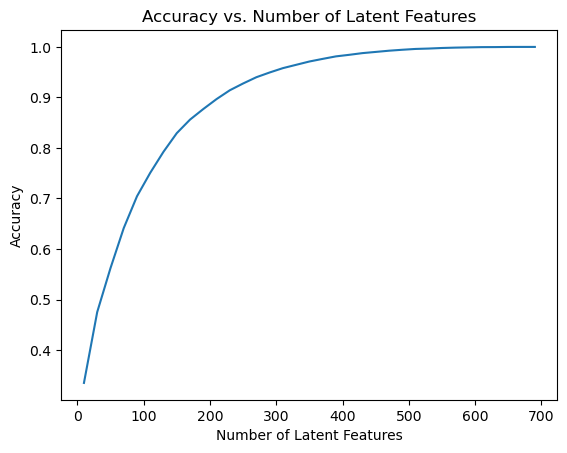

In [60]:
num_latent_feats = np.arange(10, 700 + 10,
                             20)  # arrnage no. of feature by increments of 20
#print(num_latent_feats)

sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

plt.plot(num_latent_feats, 1 - np.array(sum_errs) / df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [61]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    '''
    print("df_train shape = ", df_train.shape)
    print("df_test shape = ", df_test.shape)

    # Create user-item matrix for train set
    user_item_train = create_user_item_matrix(df_train)
    print("user_item_train shape = ", user_item_train.shape)

    # Create user-item matrix for test set
    user_item_test = create_user_item_matrix(df_test)
    print("user_item_test shape = ", user_item_test.shape)

    # Get user ids and article ids for test set
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)

    print("test_idx length = ", len(test_idx))
    print("test_arts length = ", len(test_arts))

    return user_item_train, user_item_test, test_idx, test_arts

In [62]:
# Split the data into train and test

df_train = df.head(40000)
print("df_train summary stats:\n", df_train.describe(include='all'))
df_test = df.tail(5993)
print("\ndf_test summary stats:\n", df_test.describe(include='all'))

df_train summary stats:
           article_id                                       title      user_id
count   40000.000000                                       40000  40000.00000
unique           NaN                                         714          NaN
top              NaN  use deep learning for image classification          NaN
freq             NaN                                         840          NaN
mean      911.990200                                         NaN   1930.25580
std       484.478658                                         NaN   1518.00386
min         0.000000                                         NaN      1.00000
25%       465.000000                                         NaN    483.00000
50%      1154.000000                                         NaN   1478.00000
75%      1336.000000                                         NaN   3476.00000
max      1444.000000                                         NaN   4487.00000

df_test summary stats:
          artic

In [63]:
# call the create_test_and_train_user_item using train and test dataset as parms
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(
    df_train, df_test)

df_train shape =  (40000, 3)
df_test shape =  (5993, 3)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15676\3285915201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['article_id'] = pd.to_numeric(df['article_id'], errors='coerce')


user_item_train shape =  (4487, 714)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15676\3285915201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['article_id'] = pd.to_numeric(df['article_id'], errors='coerce')


user_item_test shape =  (682, 574)
test_idx length =  682
test_arts length =  574


In [64]:
# get the set of users in the test set
test_users = set(user_item_test.index)

# get the set of users in the training set
train_users = set(user_item_train.index)

# get the set of users in the test set that are not in the training set
cold_start_users = test_users.difference(train_users)

# print the number of users with the cold start problem
print("Number of users with the cold start problem:", len(cold_start_users))

Number of users with the cold start problem: 662


In [65]:
# How many articles can we make predictions for in the test set?
# We can make predictions for all the articles in the test set because they have at least one user
# interaction in the training set. Therefore, their latent features have been learned through SVD on the training set.
print("We can make prediction for", len(test_arts),
      "articles in the test set.")

We can make prediction for 574 articles in the test set.


In [66]:
# Number of users with data in both the training and test sets

train_users = set(user_item_train.index)
test_users = set(user_item_test.index)

common_users = train_users.intersection(test_users)

num_users_with_data = len(common_users)

print("Number of users with data in both the training and test sets: ",
      num_users_with_data, "which we can predict")

Number of users with data in both the training and test sets:  20 which we can predict


In [67]:
# How many articles in the test set are we NOT able to make predictions for because of the cold start problem?
# Since we are able to make predictions for all articles in the test set, we are not facing the cold start problem
# for articles. Therefore, the answer is 0.

In [68]:
# Replace the values in the dictionary below
a = 662
b = 574
c = 20
d = 0

sol_4_dict = {
    'How many users can we make predictions for in the test set?':
    c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':
    a,
    'How many articles can we make predictions for in the test set?':
    b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':
    d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [69]:
# lets see what's in user_item_train
user_item_train.head(1)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [70]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

print("shape of user_item_train", user_item_train.shape)
print("shape of u_train=", u_train.shape)
print("shape of s_train=", s_train.shape)
print("shape of vt_train=", vt_train.shape)

shape of user_item_train (4487, 714)
shape of u_train= (4487, 4487)
shape of s_train= (714,)
shape of vt_train= (714, 714)


In [71]:
# let's look at one data point
print("u_train[1][713] =", u_train[1][713])
print("s_train[1]      =", s_train[1])
print("vt_train[1][713]=", vt_train[1][713])

u_train[1][713] = -0.016959066627116708
s_train[1]      = 21.914866739929533
vt_train[1][713]= 0.01526851322615998


In [72]:
# Use these cells to see how well you can use the training
# decomposition to predict on test data

# get indexes and columns from user item train
train_idx = np.array(user_item_train.index)
train_arts = np.array(user_item_train.columns)

# Convert user item test indexes and column lists to arrays
test_idx = np.array(test_idx)
test_arts = np.array(test_arts)

# find common users and articles between user item train and test dataframes
common_user = np.intersect1d(test_idx, train_idx)
common_articles = np.intersect1d(test_arts, train_arts)

# find indexes for those common users and common articles in test user and test article indexes
test_user_idx = np.where(np.in1d(train_idx, common_user))[0]
test_art_idx = np.where(np.in1d(train_arts, common_articles))[0]

# Create user_item_test_subset for common users with common articles
test_indexes = np.where(np.in1d(test_idx, common_user))[0]
user_item_test_subset = user_item_test.iloc[test_indexes, :]

user_item_test_subset

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3532,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3740,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


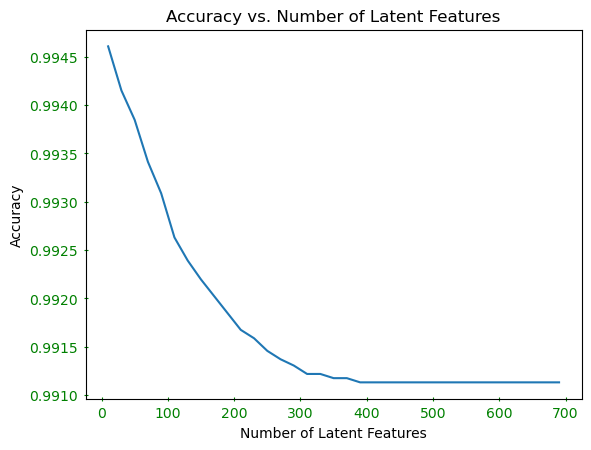

In [73]:
# predict the user_item_test_subset using the trained SVD and plot accuracy by latent features

num_latent_feats = np.arange(10, 700 + 10, 20)
#print(num_latent_feats)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(
        s_train[:k]), u_train[:, :k], vt_train[:k, :]

    u_test, vt_test = u_new[test_user_idx, :], vt_new[:, test_art_idx]

    # take dot product to predict the test data with trained-SVD-with-k-latent-featues
    user_item_test_est = np.around(np.dot(np.dot(u_test, s_new), vt_test))

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_test_est)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

plt.plot(num_latent_feats, 1 - np.array(sum_errs) / df.shape[0])
plt.tick_params(axis='both', which='major', direction='inout', colors='g')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

# Response:

As we observse from the chart above, the accuracy of the recommendation prediction reduces as the number of latent factors increase. This may be due to sparse train data and very few common users betweeen train and test dataset. However this is better than the ranked recommendation.

We might be able to improve the accuracy of the recommendation by cross-validation and more common users and articles in the train and test data sets. 

Assuming this is the first time we would deploy this solution on the website, we could implement A/B testing some users will continue with current page and rest will come to this new recommendation page. Assuming that if the user clicks on one of the recommendations, the page will be able to capture the date-timestamp which will help compare the recommendation clickthru (accuracy) rate. 

Subsequenctly we could repeat the A/B test, A model with say, 200 latent factors and B model with 300 latent factors. collect the data and compare the click-thru rate.
## ----------------------------------------------------------------------------------------------------------------------------

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [74]:
from subprocess import call

call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1